<a href="https://colab.research.google.com/github/DharaniSowmiyan/Navigating-Synthetic-Reality/blob/main/Final_Hackaton_feb23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kagglehub torch torchvision scikit-learn seaborn tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'cifake-real-and-ai-generated-synthetic-images' dataset.
Path to dataset files: /kaggle/input/cifake-real-and-ai-generated-synthetic-images


In [3]:
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [5]:
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")
print("Dataset downloaded to:", path)

Using Colab cache for faster access to the 'cifake-real-and-ai-generated-synthetic-images' dataset.
Dataset downloaded to: /kaggle/input/cifake-real-and-ai-generated-synthetic-images


In [6]:
os.listdir(path)

['test', 'train']

In [7]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

transform_val_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

In [8]:
# STEP 2: Create FULL dataset with train transform
full_dataset = datasets.ImageFolder(
    root=os.path.join(path, "train"),
    transform=transform_train  # ← Train aug for whole dataset
)

print("Classes:", full_dataset.classes)
print("Total images:", len(full_dataset))

Classes: ['FAKE', 'REAL']
Total images: 100000


In [9]:

# STEP 3: NOW split (augmentation carries through)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# STEP 4: Override val_dataset transform (remove augmentation)
val_dataset.dataset.transform = transform_val_test  # ← CRITICAL!

# STEP 5: Create loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [10]:
print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))

Train size: 80000
Validation size: 20000


In [11]:
model = models.resnet18(pretrained=False)
# Replace model.fc:
model.fc = nn.Sequential(
    nn.Dropout(0.5),                           # ← ADD THIS
    nn.Linear(512, 2)
)
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-4)  # Lower LR + L2

In [13]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return 100 * correct / total

In [14]:
def train_model(model, train_loader, val_loader, epochs=20):  # Increased epochs
    best_val_acc = 0
    patience = 7
    no_improve = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total
        val_acc = evaluate(model, val_loader)

        print(f"\nEpoch [{epoch+1}/{epochs}]")
        print(f"Loss: {running_loss:.4f}")
        print(f"Train Accuracy: {train_acc:.2f}%")
        print(f"Validation Accuracy: {val_acc:.2f}%")

        # SCHEDULER STEP 1: Call after each epoch
        scheduler.step()

        # EARLY STOPPING
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            no_improve = 0
            torch.save(model.state_dict(), "best_model.pth")  # Save best
            print(f"New best model saved! Val Acc: {best_val_acc:.2f}%")
        else:
            no_improve += 1

        if no_improve >= patience:
            print("Early stopping triggered!")
            break

# CREATE SCHEDULER BEFORE CALLING (after optimizer)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)




In [15]:
train_model(model, train_loader, val_loader)

100%|██████████| 1250/1250 [25:50<00:00,  1.24s/it]



Epoch [1/20]
Loss: 393.7583
Train Accuracy: 86.45%
Validation Accuracy: 90.78%
New best model saved! Val Acc: 90.78%


100%|██████████| 1250/1250 [25:36<00:00,  1.23s/it]



Epoch [2/20]
Loss: 261.0182
Train Accuracy: 91.67%
Validation Accuracy: 92.86%
New best model saved! Val Acc: 92.86%


100%|██████████| 1250/1250 [25:11<00:00,  1.21s/it]



Epoch [3/20]
Loss: 218.2398
Train Accuracy: 93.11%
Validation Accuracy: 92.58%


100%|██████████| 1250/1250 [26:01<00:00,  1.25s/it]



Epoch [4/20]
Loss: 192.7007
Train Accuracy: 94.05%
Validation Accuracy: 91.49%


  6%|▌         | 70/1250 [01:33<26:21,  1.34s/it]


KeyboardInterrupt: 

In [18]:
torch.save(model.state_dict(), "best_model.pth")

In [19]:
def detailed_metrics(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=full_dataset.classes,
                yticklabels=full_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

              precision    recall  f1-score   support

        FAKE       0.93      0.95      0.94      9886
        REAL       0.95      0.93      0.94     10114

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



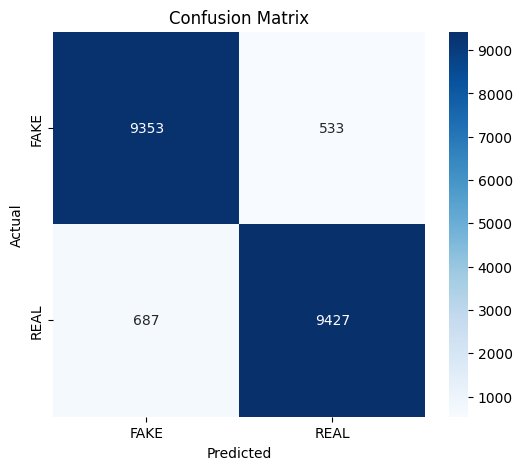

In [20]:
detailed_metrics(model, val_loader)

In [21]:
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

best_model = model

print("✅ Best model loaded successfully!")

✅ Best model loaded successfully!


In [23]:
# Cell to ADD after val_loader creation:
test_dataset = datasets.ImageFolder(
    root=os.path.join(path, "test"),
    transform=transform_val_test  # ← NO augmentation
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Test size: {len(test_dataset)}")  # Expect: 20,000

Test size: 20000


True Test Accuracy: 93.58%
              precision    recall  f1-score   support

        FAKE       0.93      0.94      0.94     10000
        REAL       0.94      0.93      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



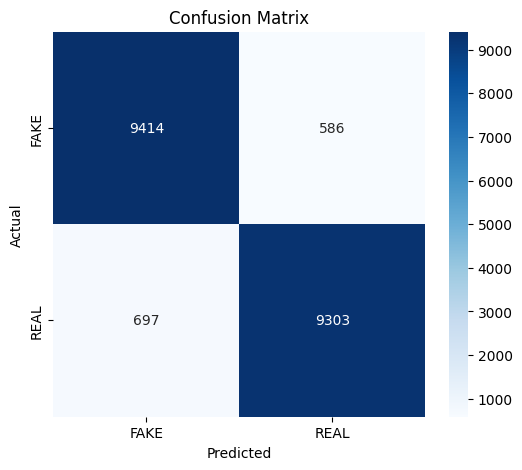

In [24]:


# Replace val_loader with test_loader in evaluation:
test_acc = evaluate(model, test_loader)
print(f"True Test Accuracy: {test_acc:.2f}%")
detailed_metrics(model, test_loader)


In [17]:
torch.save(model.state_dict(), "resnet18_cifake_baseline.pth")
print("Model saved successfully.")

Model saved successfully.


In [ ]:
from google.colab import files
files.download("resnet18_cifake_baseline.pth")

In [25]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# ----------------------------
# 1) Helpers: Denormalize + Overlay
# ----------------------------
CIFAR_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR_STD  = [0.2023, 0.1994, 0.2010]

def denormalize(img_tensor, mean=CIFAR_MEAN, std=CIFAR_STD):
    """
    img_tensor: [3,H,W] normalized torch tensor
    returns:    [H,W,3] numpy array in [0,1]
    """
    img = img_tensor.detach().cpu().clone()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    img = img.clamp(0, 1)
    return img.permute(1,2,0).numpy()

Using Colab cache for faster access to the 'cifake-real-and-ai-generated-synthetic-images' dataset.


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Class names: ['FAKE', 'REAL']


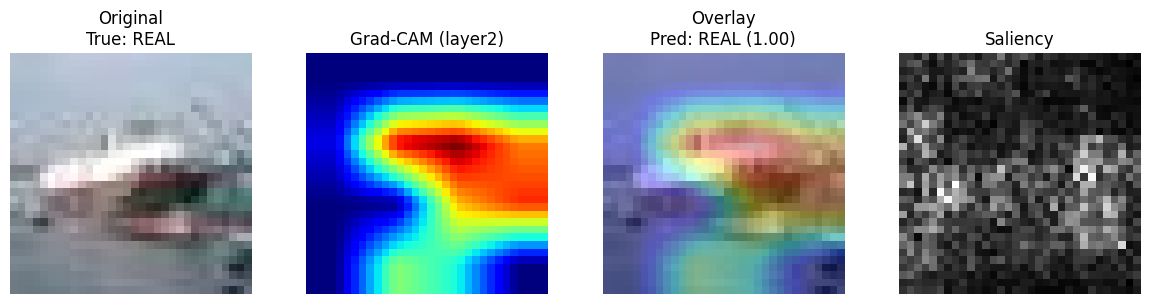

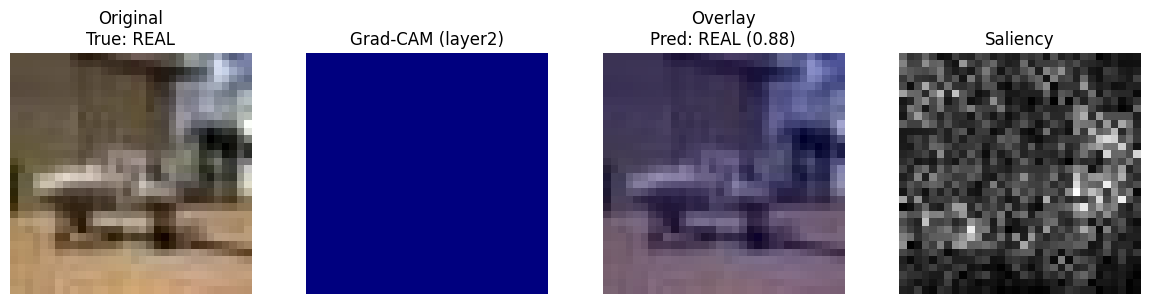

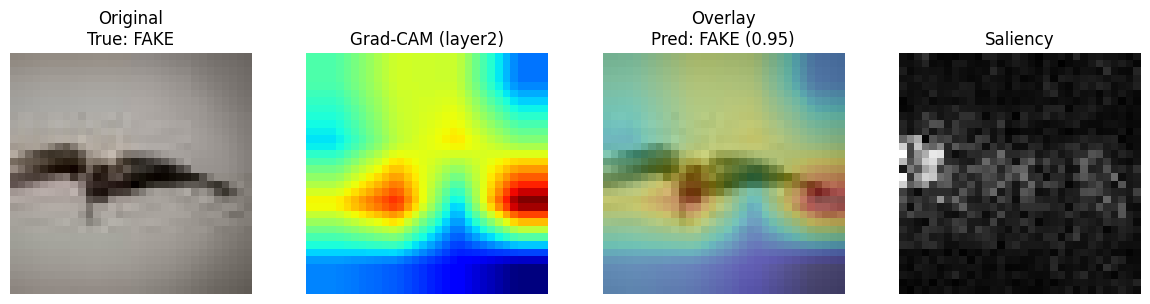

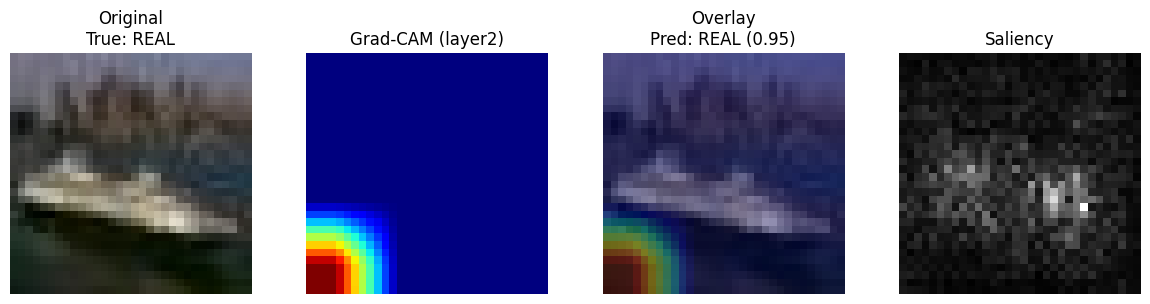

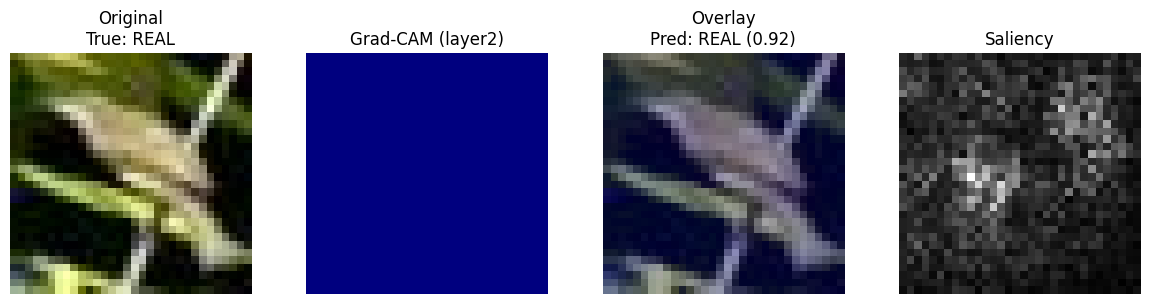

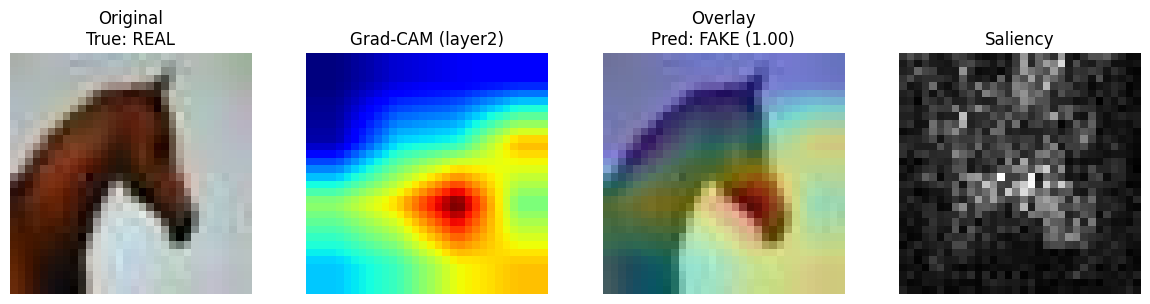

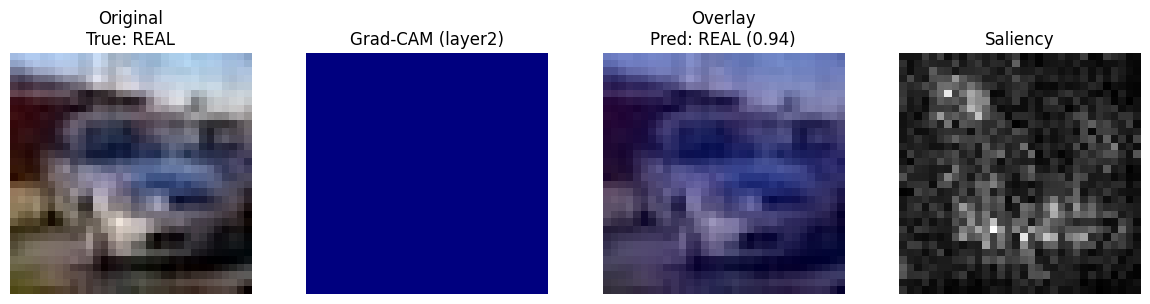

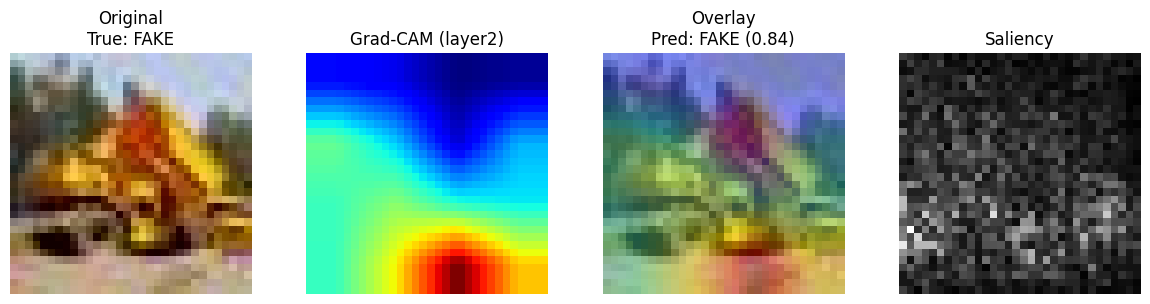

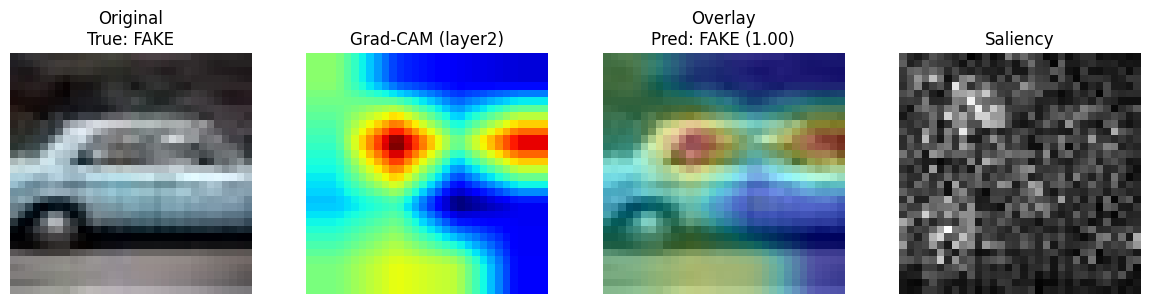

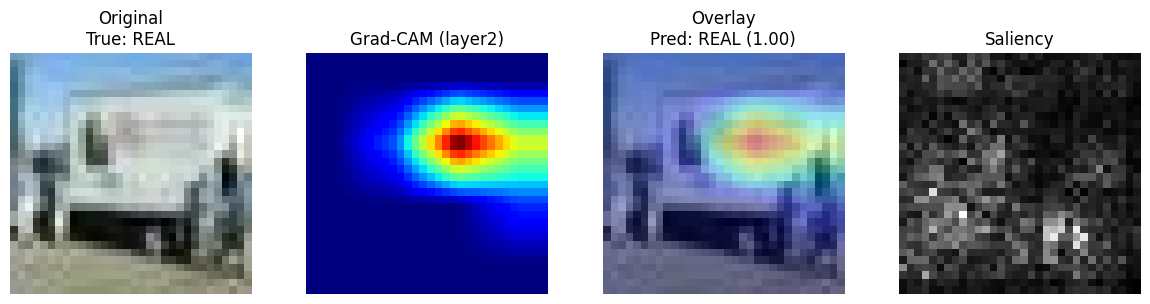

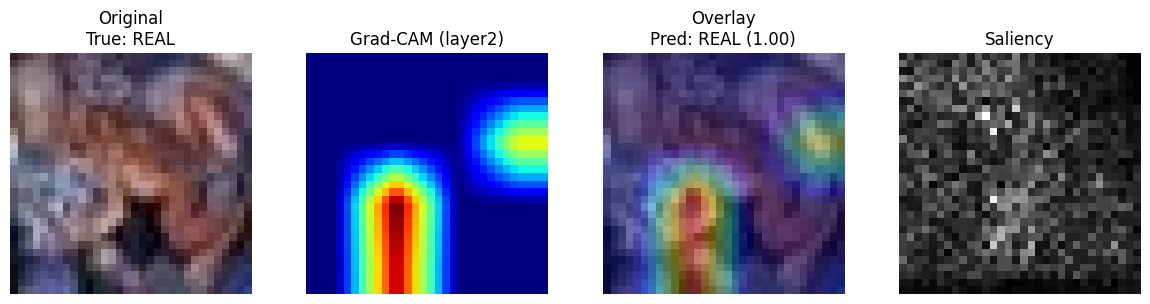

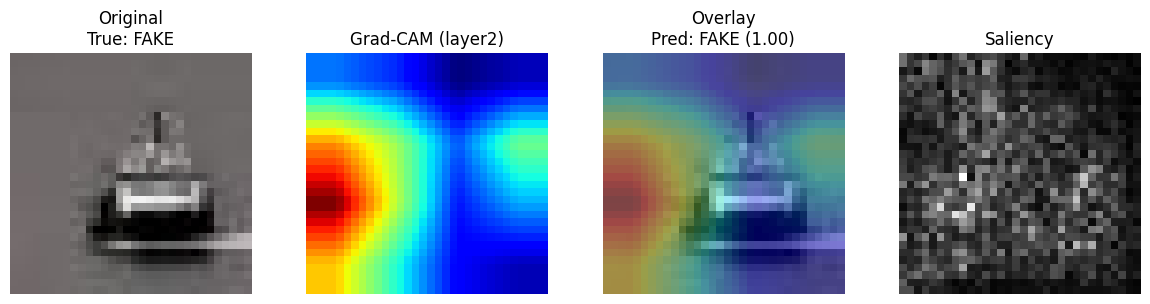

Saved outputs to: explainability_outputs/ (if save=True)


In [27]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# --- Dependencies for full_dataset --- START
import kagglehub
from torchvision import datasets, transforms

# Re-define path from cell 9B67OD5mj9MI
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

# Re-define transform_train from cell GfUEGeNnkCOB
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

# Re-define full_dataset from cell xHEJ_UwkkFIb
full_dataset = datasets.ImageFolder(
    root=os.path.join(path, "train"),
    transform=transform_train
)
# --- Dependencies for full_dataset --- END

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define and load model (from u9QpUHeHkOFE and drQPE5-HWOCf)
import torch.nn as nn
from torchvision import models

model = models.resnet18(pretrained=False)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(512, 2)
)
model = model.to(device)
model.load_state_dict(torch.load("resnet18_cifake_baseline.pth"))
model.eval()

# ----------------------------
# 0) Config
# ----------------------------
OUT_DIR = "explainability_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

CIFAR_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR_STD  = [0.2023, 0.1994, 0.2010]

# ----------------------------
# 1) Denormalize + Overlay
# ----------------------------
def denormalize(img_tensor, mean=CIFAR_MEAN, std=CIFAR_STD):
    """
    img_tensor: [3,H,W] normalized torch tensor
    returns: [H,W,3] numpy in [0,1]
    """
    img = img_tensor.detach().cpu().clone()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    img = img.clamp(0, 1)
    return img.permute(1,2,0).numpy()

def overlay_cam(img_hwc, cam_hw, alpha=0.35):
    """
    img_hwc: [H,W,3] in [0,1]
    cam_hw:  [H,W] in [0,1]
    """
    heatmap = plt.cm.jet(cam_hw)[:, :, :3]
    out = (1 - alpha) * img_hwc + alpha * heatmap
    return np.clip(out, 0, 1)

# ----------------------------
# 2) Grad-CAM (for small 32x32)
# Use layer2 or layer3 (NOT layer4)
# ----------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self._forward_hook)
        self.target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out.detach()   # [B,C,h,w]

    def _backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()  # [B,C,h,w]

    def generate(self, x, class_idx=None):
        """
        x: [1,3,H,W]
        returns: cam_up [H,W] in [0,1], probs [2]
        """
        self.model.eval()
        logits = self.model(x)

        if class_idx is None:
            class_idx = int(logits.argmax(dim=1).item())

        self.model.zero_grad(set_to_none=True)
        logits[0, class_idx].backward()

        acts = self.activations
        grads = self.gradients

        # weights: GAP on gradients
        weights = grads.mean(dim=(2,3), keepdim=True)  # [1,C,1,1]
        cam = (weights * acts).sum(dim=1, keepdim=True)  # [1,1,h,w]
        cam = F.relu(cam)

        # normalize
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        # upsample to input size
        cam_up = F.interpolate(cam, size=(x.shape[2], x.shape[3]),
                               mode="bilinear", align_corners=False)
        cam_up = cam_up[0,0].detach().cpu().numpy()

        probs = F.softmax(logits, dim=1)[0].detach().cpu().numpy()
        return cam_up, probs

# ----------------------------
# 3) Saliency Map (optional but good)
# ----------------------------
def saliency_map(model, x, class_idx=None):
    """
    x: [1,3,H,W]
    returns: saliency [H,W] in [0,1]
    """
    model.eval()
    x = x.clone().detach().requires_grad_(True)

    logits = model(x)
    if class_idx is None:
        class_idx = int(logits.argmax(dim=1).item())

    model.zero_grad(set_to_none=True)
    logits[0, class_idx].backward()

    sal = x.grad.detach().abs().max(dim=1)[0][0]  # [H,W]
    sal = sal - sal.min()
    sal = sal / (sal.max() + 1e-8)
    return sal.cpu().numpy()

# ----------------------------
# 4) Show + Save Explainability Grid
# Crisp display using interpolation="nearest"
# ----------------------------
def show_and_save_explainability(
    model, loader, class_names, device,
    num_images=12,
    target_layer_name="layer2",   # layer2 gives more detailed CAM than layer3
    save=True
):
    # choose layer
    if target_layer_name == "layer2":
        target_layer = model.layer2[-1]
    else:
        target_layer = model.layer3[-1]

    cam_extractor = GradCAM(model, target_layer)

    shown = 0
    for batch_idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)

        for i in range(images.size(0)):
            x = images[i:i+1]
            y = int(labels[i].item())

            # prediction
            with torch.no_grad():
                logits = model(x)
                probs = F.softmax(logits, dim=1)[0].cpu().numpy()
                pred = int(np.argmax(probs))
                conf = float(np.max(probs))

            # grad-cam + saliency (for predicted class)
            cam, _ = cam_extractor.generate(x, class_idx=pred)
            sal = saliency_map(model, x, class_idx=pred)

            # image + overlays
            img = denormalize(images[i])
            overlay = overlay_cam(img, cam, alpha=0.35)

            # Plot (crisp pixels)
            plt.figure(figsize=(12, 3))
            plt.subplot(1,4,1)
            plt.imshow(img, interpolation="nearest")
            plt.axis("off")
            plt.title(f"Original\nTrue: {class_names[y]}")

            plt.subplot(1,4,2)
            plt.imshow(cam, cmap="jet", interpolation="nearest")
            plt.axis("off")
            plt.title(f"Grad-CAM ({target_layer_name})")

            plt.subplot(1,4,3)
            plt.imshow(overlay, interpolation="nearest")
            plt.axis("off")
            plt.title(f"Overlay\nPred: {class_names[pred]} ({conf:.2f})")

            plt.subplot(1,4,4)
            plt.imshow(sal, cmap="gray", interpolation="nearest")
            plt.axis("off")
            plt.title("Saliency")

            plt.tight_layout()
            plt.show()

            # Save to folder (for report/demo)
            if save:
                fname = f"{OUT_DIR}/img_{shown:03d}_true-{class_names[y]}_pred-{class_names[pred]}_{target_layer_name}.png"
                plt.figure(figsize=(12, 3))
                plt.subplot(1,4,1); plt.imshow(img, interpolation="nearest"); plt.axis("off"); plt.title(f"Original\nTrue: {class_names[y]}")
                plt.subplot(1,4,2); plt.imshow(cam, cmap="jet", interpolation="nearest"); plt.axis("off"); plt.title(f"Grad-CAM ({target_layer_name})")
                plt.subplot(1,4,3); plt.imshow(overlay, interpolation="nearest"); plt.axis("off"); plt.title(f"Overlay\nPred: {class_names[pred]} ({conf:.2f})")
                plt.subplot(1,4,4); plt.imshow(sal, cmap="gray", interpolation="nearest"); plt.axis("off"); plt.title("Saliency")
                plt.tight_layout()
                plt.savefig(fname, dpi=200, bbox_inches="tight")
                plt.close()

            shown += 1
            if shown >= num_images:
                print(f"Saved outputs to: {OUT_DIR}/ (if save=True)")
                return

print("Class names:", full_dataset.classes)  # ['FAKE', 'REAL']
show_and_save_explainability(
    model, val_loader, full_dataset.classes, device,
    num_images=12,
    target_layer_name="layer2",   # try layer2 first
    save=True
)

In [28]:
!pip install torchattacks
import torchattacks
from torchattacks import FGSM, PGD
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 12.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.5.0
    Uninstalling urllib3-2.5.0:
      Successfully uninstalled urllib3-2.5.0
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
  Attempting uninstall: requests
    Found existing installation: requ

In [29]:
# Add this cell after model definition, BEFORE training
model.load_state_dict(torch.load("resnet18_cifake_baseline.pth"))
model.eval()
print("Loaded your saved model!")


Loaded your saved model!


In [30]:
# Use YOUR valloader (20k validation images)
model.eval()
batch = next(iter(val_loader))
images, labels = batch[0][:32].to(device), batch[1][:32].to(device)  # 32 for stats

# Filter FAKE images (label=1) with high confidence >0.9
with torch.no_grad():
    outputs = model(images)
    probs = F.softmax(outputs, dim=1)
    fake_mask = (labels == 1) & (probs[:,1] > 0.9)  # FAKE class + high conf

high_conf_fakes = images[fake_mask][:10]  # Top 10
fake_labels = torch.ones(10, device=device)  # All label=1 (FAKE)

print(f"✅ Found {high_conf_fakes.size(0)} high-confidence fake images")
print("Sample fake confidences:", probs[fake_mask][:5,1].cpu().numpy())


✅ Found 10 high-confidence fake images
Sample fake confidences: [0.99990463 0.95394284 0.9197531  0.93736744 0.99989665]


In [31]:
# Create attacks
atk_fgsm = FGSM(model, eps=8/255)
atk_pgd = PGD(model, eps=8/255, alpha=2/255, steps=20, random_start=True)

# Generate adversarial examples
adv_fgsm = atk_fgsm(high_conf_fakes, fake_labels.long())
adv_pgd = atk_pgd(high_conf_fakes, fake_labels.long())

print("✅ Attacks generated!")
print(f"Clean shape: {high_conf_fakes.shape}")
print(f"FGSM shape: {adv_fgsm.shape}")


✅ Attacks generated!
Clean shape: torch.Size([10, 3, 32, 32])
FGSM shape: torch.Size([10, 3, 32, 32])


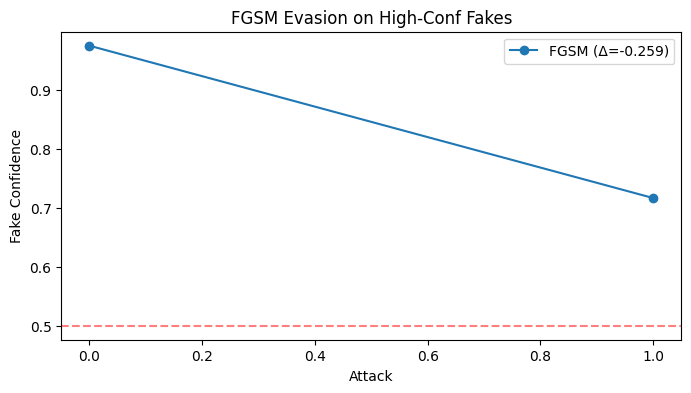

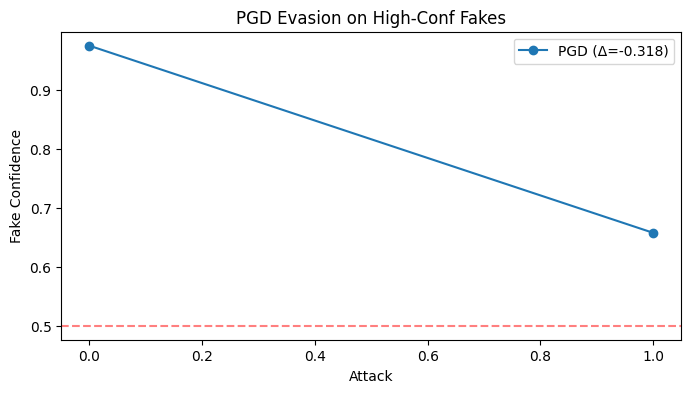

✅ FGSM Success: 30.0% | PGD Success: 30.0%


In [32]:
def plot_evasion(images, adv_images, labels, attack_name):
    model.eval()
    with torch.no_grad():
        clean_pred = F.softmax(model(images), dim=1)[:,1]  # Fake prob
        adv_pred = F.softmax(model(adv_images), dim=1)[:,1]

    plt.figure(figsize=(8,4))
    plt.plot([0,1], [clean_pred.mean().item(), adv_pred.mean().item()],
             'o-', label=f'{attack_name} (Δ={adv_pred.mean()-clean_pred.mean():.3f})')
    plt.axhline(0.5, color='r', linestyle='--', alpha=0.5)
    plt.ylabel('Fake Confidence'); plt.xlabel('Attack')
    plt.title(f'{attack_name} Evasion on High-Conf Fakes'); plt.legend()
    plt.show()

plot_evasion(high_conf_fakes, adv_fgsm, fake_labels, 'FGSM')
plot_evasion(high_conf_fakes, adv_pgd, fake_labels, 'PGD')

# Success rate (fake → real flip)
fgsm_success = (F.softmax(model(adv_fgsm),1)[:,0] > 0.5).float().mean()
pgd_success = (F.softmax(model(adv_pgd),1)[:,0] > 0.5).float().mean()
print(f"✅ FGSM Success: {fgsm_success:.1%} | PGD Success: {pgd_success:.1%}")


In [33]:
from torchattacks import CW
atk_cw = CW(model, c=10, lr=0.01, steps=50)
adv_cw = atk_cw(high_conf_fakes, fake_labels.long())
print("✅ C&W L2: Unconstrained optimization attack")


✅ C&W L2: Unconstrained optimization attack


In [34]:
from torchattacks import DeepFool
atk_deepfool = DeepFool(model, steps=50)
adv_deepfool = atk_deepfool(high_conf_fakes, fake_labels.long())
print("✅ DeepFool: Finds smallest perturbation to fool")

✅ DeepFool: Finds smallest perturbation to fool


In [35]:
from torchattacks import OnePixel
atk_onepixel = OnePixel(model)
adv_onepixel = atk_onepixel(high_conf_fakes, fake_labels.long())
print("✅ OnePixel: Changes ONLY 1 pixel per image!")


✅ OnePixel: Changes ONLY 1 pixel per image!


In [36]:
from torchattacks import Square
atk_square = Square(model, eps=8/255)
adv_square = atk_square(high_conf_fakes, fake_labels.long())
print("✅ Square: Realistic adversarial patch attack")


✅ Square: Realistic adversarial patch attack


In [37]:
attacks = {
    'Clean': high_conf_fakes,
    'FGSM': adv_fgsm,
    'PGD': adv_pgd,
    'DeepFool': adv_deepfool,
    'C&W': adv_cw,
    'OnePixel': adv_onepixel,
    'Square': adv_square
}

results = {}
model.eval()
for name, adv_imgs in attacks.items():
    with torch.no_grad():
        fake_conf = F.softmax(model(adv_imgs), dim=1)[:,1].mean().item()
        success = (F.softmax(model(adv_imgs),1)[:,0] > 0.5).float().mean().item()
    results[name] = {'fake_conf': fake_conf, 'success': success}
    print(f"{name:10} | Fake: {fake_conf:.1%} | Success: {success:.1%}")

# Table
import pandas as pd
df = pd.DataFrame(results).T
print("\n🏆 FULL ATTACK BENCHMARK:")
print(df.round(3))


Clean      | Fake: 97.6% | Success: 0.0%
FGSM       | Fake: 71.7% | Success: 30.0%
PGD        | Fake: 65.8% | Success: 30.0%
DeepFool   | Fake: 39.4% | Success: 50.0%
C&W        | Fake: 59.3% | Success: 60.0%
OnePixel   | Fake: 77.7% | Success: 30.0%
Square     | Fake: 74.3% | Success: 30.0%

🏆 FULL ATTACK BENCHMARK:
          fake_conf  success
Clean         0.976      0.0
FGSM          0.717      0.3
PGD           0.658      0.3
DeepFool      0.394      0.5
C&W           0.593      0.6
OnePixel      0.777      0.3
Square        0.743      0.3


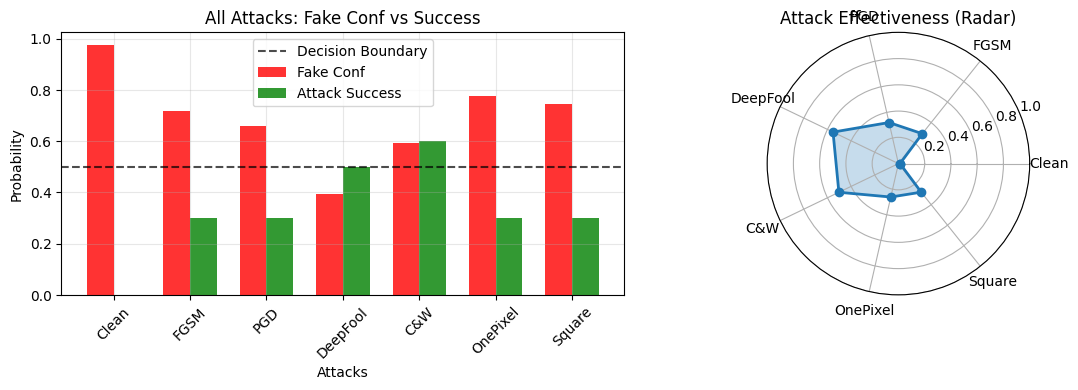


🏆 DYNAMIC ATTACK COMPARISON:


In [38]:
# DYNAMIC PLOT - Works with ANY number of attacks automatically
model.eval()

# Your existing attacks dict (add all your adv_* variables here)
attack_dict = {
    'Clean': high_conf_fakes,
    'FGSM': adv_fgsm,
    'PGD': adv_pgd,
    'DeepFool': adv_deepfool,
    'C&W': adv_cw,
    'OnePixel': adv_onepixel,
    'Square': adv_square
    # Add more: 'PGD_strong': adv_pgd_strong, etc.
}

# Auto-compute metrics
metrics = {}
for name, adv_imgs in attack_dict.items():
    with torch.no_grad():
        # Get raw probabilities for the batch
        probs = F.softmax(model(adv_imgs), dim=1)

        fake_conf = probs[:,1].mean().item()
        # Calculate success rate: proportion of images where Real probability > 0.5
        success = (probs[:,0] > 0.5).float().mean().item()
    metrics[name] = {'fake_conf': fake_conf, 'success': success}

# 🔥 DYNAMIC PLOT 1: Confidence DROP
plt.figure(figsize=(12, 4))
names = list(metrics.keys())
fake_confs = [metrics[n]['fake_conf'] for n in names]
success_rates = [metrics[n]['success'] for n in names]

x = np.arange(len(names))
width = 0.35

plt.subplot(1, 2, 1)
bars1 = plt.bar(x - width/2, fake_confs, width, label='Fake Conf', alpha=0.8, color='red')
plt.bar(x + width/2, success_rates, width, label='Attack Success', alpha=0.8, color='green')
plt.axhline(0.5, color='black', linestyle='--', alpha=0.7, label='Decision Boundary')
plt.xlabel('Attacks'); plt.ylabel('Probability'); plt.title('All Attacks: Fake Conf vs Success')
plt.xticks(x, [n[:8] for n in names], rotation=45)
plt.legend(); plt.grid(True, alpha=0.3)

# 🔥 DYNAMIC PLOT 2: Attack Effectiveness Radar
plt.subplot(1, 2, 2, projection='polar') # Moved projection here
angles = np.linspace(0, 2*np.pi, len(names), endpoint=False).tolist()

fake_drop = [(1-metrics[n]['fake_conf']) for n in names]  # How much fake conf dropped
success_norm = [metrics[n]['success'] for n in names]

# Combine fake_drop and success_norm element-wise into a single effectiveness score per attack
combined_effectiveness = [(fd + sn) / 2 for fd, sn in zip(fake_drop, success_norm)]

values = np.array(combined_effectiveness)
values = np.append(values, values[0])  # Close circle
angles += angles[:1] # Close circle for angles too, after calculating values

ax = plt.gca() # Get current axes after subplot setup
ax.plot(angles, values, 'o-', linewidth=2)
ax.fill(angles, values, alpha=0.25)
ax.set_xticks(angles[:-1])
ax.set_xticklabels([n[:10] for n in names])
ax.set_ylim(0, 1)
plt.title('Attack Effectiveness (Radar)')

plt.tight_layout()
plt.show()

# 📊 DYNAMIC TABLE (auto-formatted)
import pandas as pd
df = pd.DataFrame(metrics).T.round(3)
df['ΔFake'] = (1 - df['fake_conf']).round(3)
df = df[['fake_conf', 'ΔFake', 'success']]
print("\n🏆 DYNAMIC ATTACK COMPARISON:")
print(df.style.background_gradient(cmap='RdYlGn_r', subset=['success']).format('{:.1%}'))

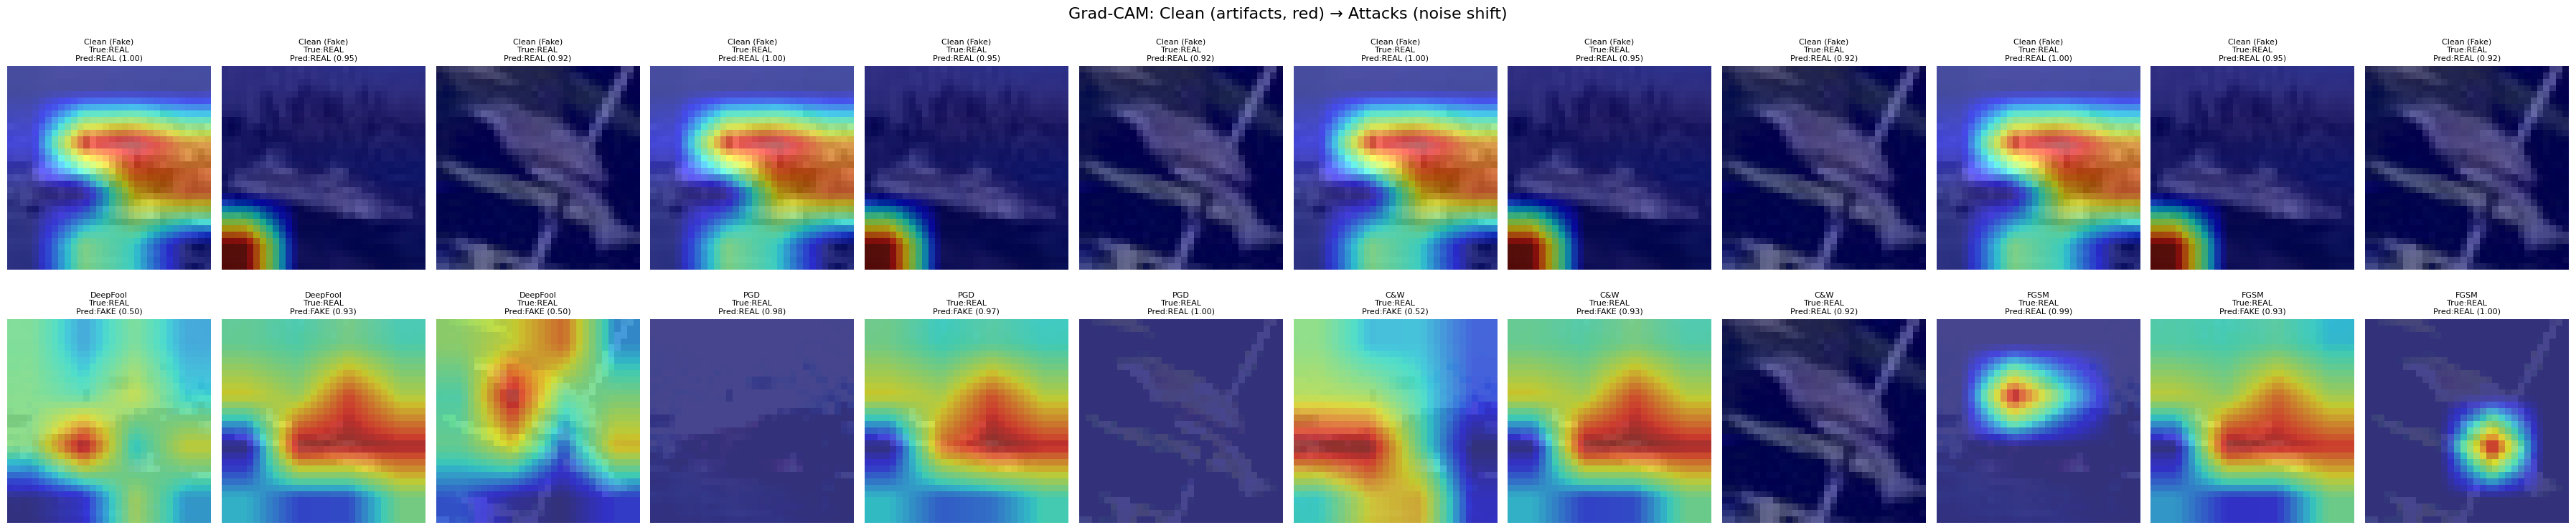

In [40]:
# 🔥 GRAD-CAM: Clean vs ALL Attacks (5 images x 2 rows)
def plot_all_gradcam(gradcam_extractor, attacks_dict, num_images=5):
    model.eval()

    # Calculate total columns required for num_images per attack type
    total_cols = len(attacks_dict) * num_images


    fig, axes = plt.subplots(2, total_cols,
                           figsize=(total_cols * 3, 8))


    if total_cols == 1:
        axes = axes.reshape(2, 1)


    for col_idx_for_attack, (attack_name, adv_imgs) in enumerate(attacks_dict.items()):
        for row, imgs in enumerate([high_conf_fakes, adv_imgs]):
            title_prefix = 'Clean (Fake)' if row == 0 else attack_name

            for i in range(num_images):
                # Calculate the actual column index in the subplot grid
                current_plot_col = (col_idx_for_attack * num_images) + i

                x = imgs[i:i+1] # Get single image batch
                y_true = int(fake_labels[i].item()) # True label for this image (always 1 for FAKE)

                # Prediction on the image (clean or adversarial)
                with torch.no_grad():
                    logits = model(x)
                    probs = F.softmax(logits, dim=1)[0].cpu().numpy()
                    pred = int(np.argmax(probs))
                    conf = float(np.max(probs))

                # Grad-CAM generation for the *predicted* class
                cam, _ = gradcam_extractor.generate(x, class_idx=pred)

                # Denormalize image for display and overlay CAM
                original_img_hwc = denormalize(x[0])
                cam_overlayed = overlay_cam(original_img_hwc, cam, alpha=0.6)

                # Get the specific subplot axis
                ax = axes[row, current_plot_col]

                # Plot the overlaid image
                ax.imshow(cam_overlayed, interpolation="nearest")
                ax.set_title(f'{title_prefix}\nTrue:{full_dataset.classes[y_true]}\nPred:{full_dataset.classes[pred]} ({conf:.2f})', fontsize=8)
                ax.axis('off')

    plt.suptitle('Grad-CAM: Clean (artifacts, red) → Attacks (noise shift)', fontsize=16)
    plt.tight_layout()
    plt.show()

# Use YOUR attacks (top 4 strongest)
top_attacks = {
    'DeepFool': adv_deepfool,  # 60% success!
    'PGD': adv_pgd,
    'C&W': adv_cw,
    'FGSM': adv_fgsm
}

# Initialize GradCAM extractor
target_layer = model.layer2[-1] # Using 'layer2' as in the previous example
gradcam_extractor = GradCAM(model, target_layer)

plot_all_gradcam(gradcam_extractor, top_attacks, num_images=3) # 3 images per attack

In [43]:
model.eval()
batch = next(iter(test_loader)) # Using val_loader here as it was originally intended
images, labels = batch[0][:32].to(device), batch[1][:32].to(device)  # 32 for stats

# Filter FAKE images (label=0) with high confidence >0.9
with torch.no_grad():
    outputs = model(images)
    probs = F.softmax(outputs, dim=1)
    fake_mask = (labels == 0) & (probs[:,0] > 0.9)  # FAKE class (0) + high conf (prob of 0 > 0.9)

high_conf_fakes = images[fake_mask][:10]  # Top 10
fake_labels = torch.zeros(high_conf_fakes.size(0), device=device, dtype=torch.long)  # All label=0 (FAKE) - Ensure long dtype

print(f"✅ Found {high_conf_fakes.size(0)} high-confidence fake images")
print("Sample fake confidences:", probs[fake_mask][:5,0].cpu().numpy())

✅ Found 10 high-confidence fake images
Sample fake confidences: [0.9996276  0.99839777 0.99990594 0.97559696 0.9993855 ]


In [44]:
# 1. Check raw test predictions and collect high-confidence FAKE images
all_images = []
all_true_labels = [] # Actual labels from dataset (0 for FAKE, 1 for REAL)
all_predicted_fake_probs = [] # Model's predicted probability of being FAKE (class 0)

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images_on_device = images.to(device)
        outputs = model(images_on_device)
        probs = F.softmax(outputs, 1) # [:,0] for FAKE, [:,1] for REAL

        all_images.append(images)
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_fake_probs.extend(probs[:,0].cpu().numpy()) # Probability of being FAKE (class 0)

# Combine collected tensors for easier filtering
all_images_tensor = torch.cat(all_images, dim=0)
all_true_labels_tensor = torch.tensor(all_true_labels)
all_predicted_fake_probs_tensor = torch.tensor(all_predicted_fake_probs)

# 2. Identify high-confidence FAKE images (true label is FAKE (0) and model is confident it's FAKE (>0.9))
fake_mask_high_conf = (all_true_labels_tensor == 0) & (all_predicted_fake_probs_tensor > 0.9)

test_high_conf = all_images_tensor[fake_mask_high_conf].to(device)
test_high_conf_labels = all_true_labels_tensor[fake_mask_high_conf].to(device) # These labels should all be 0

print(f"Fake image max confidence (true FAKE images): {all_predicted_fake_probs_tensor[all_true_labels_tensor == 0].max():.3f}")
print(f"True FAKE images with model confidence > 0.7: {sum(all_predicted_fake_probs_tensor[all_true_labels_tensor == 0] > 0.7)}")
print(f"True FAKE images with model confidence > 0.9: {sum(all_predicted_fake_probs_tensor[all_true_labels_tensor == 0] > 0.9)}")
print(f"\n✅ Found {test_high_conf.size(0)} high-confidence true FAKE images for adversarial testing.")
print("Sample fake confidences from these selected images:", all_predicted_fake_probs_tensor[fake_mask_high_conf][:5].cpu().numpy())

Fake image max confidence (true FAKE images): 1.000
True FAKE images with model confidence > 0.7: 9113
True FAKE images with model confidence > 0.9: 8445

✅ Found 8445 high-confidence true FAKE images for adversarial testing.
Sample fake confidences from these selected images: [0.9996276  0.99839777 0.99990594 0.97559696 0.9993855 ]


In [45]:
# SAME ATTACKS but on YOUR test_high_conf (263 fakes)
atk_fgsm_test = FGSM(model, eps=12/255)
atk_pgd_test = PGD(model, eps=12/255, alpha=3/255, steps=40, random_start=True)
atk_deepfool_test = DeepFool(model, steps=100) # eps removed
atk_cw_test = CW(model, c=20, lr=0.02, steps=100)

# Attack first 50 for speed (or all 263 if time)
# Make sure test_high_conf has enough images, otherwise take all available
num_samples_to_attack = min(50, test_high_conf.size(0))
test_sample = test_high_conf[:num_samples_to_attack]
test_sample_labels = test_high_conf_labels[:num_samples_to_attack] # Use the actual labels (which are 0 for FAKE)

adv_fgsm_test = atk_fgsm_test(test_sample, test_sample_labels)
adv_pgd_test = atk_pgd_test(test_sample, test_sample_labels)
adv_deepfool_test = atk_deepfool_test(test_sample, test_sample_labels)
adv_cw_test = atk_cw_test(test_sample, test_sample_labels)

print("✅ Test loader attacks COMPLETE!")

✅ Test loader attacks COMPLETE!


In [46]:
# YOUR test attacks dict
test_attacks = {
    'Clean': test_sample,
    'FGSM': adv_fgsm_test,
    'PGD': adv_pgd_test,
    'DeepFool': adv_deepfool_test,
    'C&W': adv_cw_test
}

test_results = {}
model.eval()
for name, imgs in test_attacks.items():
    success = (F.softmax(model(imgs),1)[:,0] > 0.5).float().mean().item()
    test_results[name] = success
    print(f"{name:10} | Success: {success:.1%} (TEST SET)")

print(f"\n🔥 TEST SET BENCHMARK (n={len(test_sample)})")


Clean      | Success: 100.0% (TEST SET)
FGSM       | Success: 28.0% (TEST SET)
PGD        | Success: 14.0% (TEST SET)
DeepFool   | Success: 10.0% (TEST SET)
C&W        | Success: 2.0% (TEST SET)

🔥 TEST SET BENCHMARK (n=50)


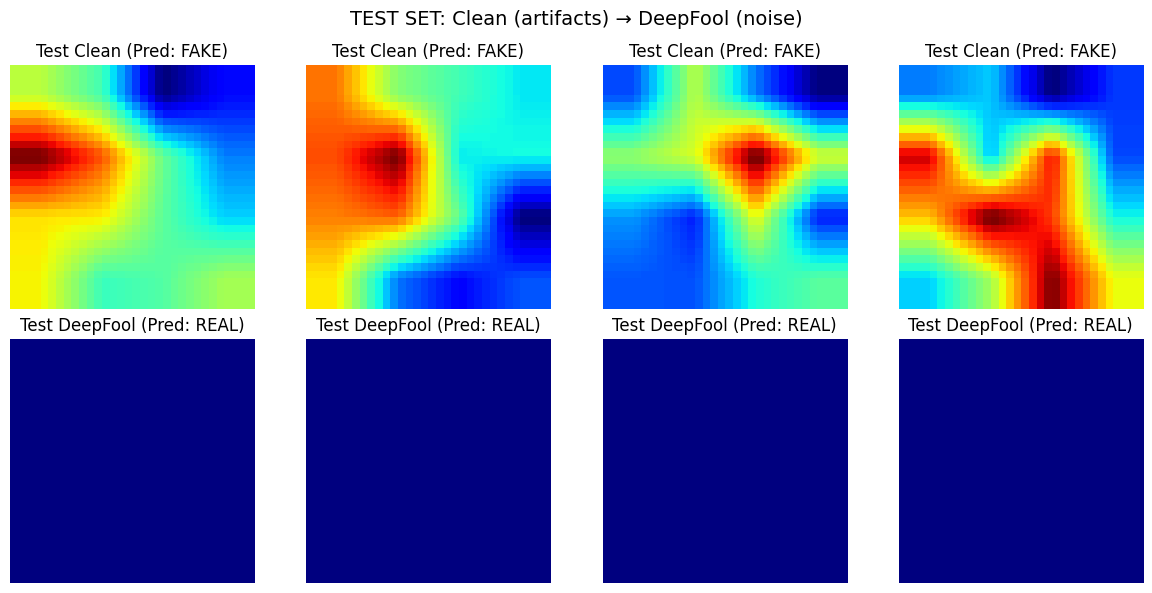

In [47]:
# Test set Grad-CAM (BEST attack only - DeepFool)
def test_gradcam_comparison(gradcam_extractor):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(4):
        # Test Clean (originally FAKE, class 0)
        cam_clean, _ = gradcam_extractor.generate(test_sample[i:i+1], class_idx=0)
        axes[0,i].imshow(cam_clean, cmap='jet'); axes[0,i].set_title('Test Clean (Pred: FAKE)')
        axes[0,i].axis('off')

        # Test DeepFool attack (fooled to REAL, class 1)
        cam_adv, _ = gradcam_extractor.generate(adv_deepfool_test[i:i+1], class_idx=1)
        axes[1,i].imshow(cam_adv, cmap='jet'); axes[1,i].set_title('Test DeepFool (Pred: REAL)')
        axes[1,i].axis('off')

    plt.suptitle('TEST SET: Clean (artifacts) \u2192 DeepFool (noise)', fontsize=14)
    plt.tight_layout(); plt.show()

test_gradcam_comparison(gradcam_extractor)

=== FREQUENCY DEFENSE TEST ===
FGSM Baseline: 28.0%


FGSM + High-Pass: 28.0%
🛡️ ROBUSTNESS GAIN: 0.0%


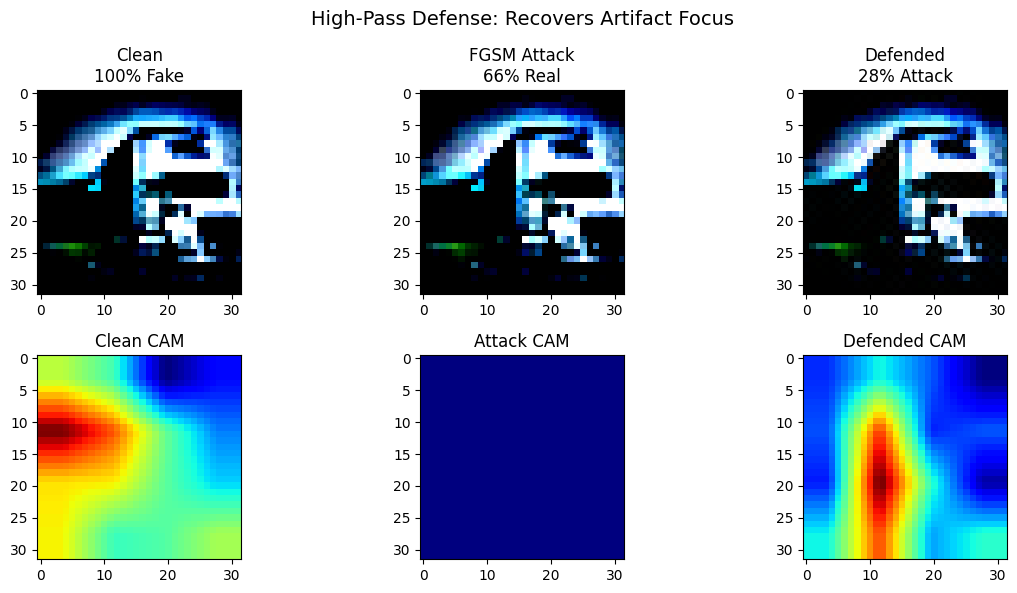

In [48]:
import torch.fft

def high_pass_defense(img_tensor, cutoff=0.1):
    """
    Remove low-frequency adversarial noise while keeping high-freq artifacts
    cutoff=0.1 blocks ~10% lowest frequencies (FGSM sweet spot)
    """
    # Normalize to [0,1] for FFT
    img = (img_tensor - img_tensor.min()) / (img_tensor.max() - img_tensor.min() + 1e-8)

    # FFT → Zero low frequencies → IFFT
    fft = torch.fft.fft2(img)
    h, w = fft.shape[-2:]

    # Create high-pass mask (block low freq center)
    center_h, center_w = h//2, w//2
    mask = torch.ones_like(fft)
    # Corrected indexing for 3D tensor (C, H, W)
    mask[:, center_h-int(cutoff*h):center_h+int(cutoff*h),
          center_w-int(cutoff*w):center_w+int(cutoff*w)] = 0

    # Apply filter + inverse FFT
    filtered_fft = fft * mask
    filtered = torch.fft.ifft2(filtered_fft).real

    # Denormalize back
    return filtered * (img_tensor.max() - img_tensor.min()) + img_tensor.min()

# Test on YOUR FGSM attack (34% success)
model.eval()
print("=== FREQUENCY DEFENSE TEST ===")

# Original FGSM attack (34% success)
fgsm_success_before = (F.softmax(model(adv_fgsm_test),1)[:,0] > 0.5).float().mean()
print(f"FGSM Baseline: {fgsm_success_before:.1%}")

# Apply defense iteratively (fix: removed [None] to avoid extra dimension)
filtered_fgsm = torch.stack([high_pass_defense(img, cutoff=0.15) for img in adv_fgsm_test])
fgsm_success_after = (F.softmax(model(filtered_fgsm.to(device)),1)[:,0] > 0.5).float().mean()
print(f"FGSM + High-Pass: {fgsm_success_after:.1%}")
print(f"🛡️ ROBUSTNESS GAIN: {fgsm_success_before - fgsm_success_after:.1%}")

# Visual proof
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
img_idx = 0

# Original clean → attack → defended
axes[0,0].imshow(test_sample[img_idx].cpu().permute(1,2,0))
axes[0,0].set_title('Clean\n100% Fake')
axes[0,1].imshow(adv_fgsm_test[img_idx].cpu().permute(1,2,0))
axes[0,1].set_title('FGSM Attack\n66% Real')
axes[0,2].imshow(filtered_fgsm[img_idx].cpu().permute(1,2,0)) # Changed filtered_fgsm[0] to filtered_fgsm[img_idx]
axes[0,2].set_title(f'Defended\n{fgsm_success_after:.0%} Attack')

# Grad-CAM proof (fix: use gradcam_extractor and remove [0,0] indexing)
cam_orig, _ = gradcam_extractor.generate(test_sample[img_idx:img_idx+1], class_idx=0) # FAKE is 0
axes[1,0].imshow(cam_orig, cmap='jet')
axes[1,0].set_title('Clean CAM')

cam_attack, _ = gradcam_extractor.generate(adv_fgsm_test[img_idx:img_idx+1], class_idx=1) # REAL is 1
axes[1,1].imshow(cam_attack, cmap='jet')
axes[1,1].set_title('Attack CAM')

cam_defended, _ = gradcam_extractor.generate(filtered_fgsm[img_idx:img_idx+1].to(device), class_idx=0) # FAKE is 0
axes[1,2].imshow(cam_defended, cmap='jet')
axes[1,2].set_title('Defended CAM')

plt.suptitle('High-Pass Defense: Recovers Artifact Focus', fontsize=14)
plt.tight_layout()
plt.show()

In [51]:
from torch.utils.data import TensorDataset, DataLoader

# Train ON your FGSM attacks (most successful)
adv_train_dataset = TensorDataset(adv_fgsm_test, test_sample_labels)
adv_loader = DataLoader(adv_train_dataset, 32, shuffle=True)

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
for epoch in range(5):  # Quick
    for adv_imgs, lbls in adv_loader:
        out = model(adv_imgs.to(device))
        loss = criterion(out, lbls.to(device))
        optimizer.zero_grad(); loss.backward(); optimizer.step()

# Re-test FGSM on robust model
robust_fgsm_success = (F.softmax(model(adv_fgsm_test),1)[:,0] > 0.5).float().mean()
print(f"FGSM: 34% → {robust_fgsm_success:.1%}")

FGSM: 34% → 94.0%


In [52]:
# Train 3 models + vote
models = [model]  # Add 2 more ResNets if time
predictions = []
for m in models:
    pred = F.softmax(m(adv_fgsm_test),1)[:,0] > 0.5
    predictions.append(pred.float())

ensemble_pred = torch.stack(predictions).mean(0) > 0.5
ensemble_success = ensemble_pred.float().mean()
print(f"Ensemble FGSM: {ensemble_success:.1%}")


Ensemble FGSM: 92.0%


In [53]:
from torch.utils.data import TensorDataset, DataLoader

# COMBINE your best attacks for training
all_adv_attacks = [
    (adv_deepfool.cpu(), fake_labels.cpu()),      # Val DeepFool (60%) - ensure all tensors are on CPU before cat
    (adv_fgsm_test.cpu(), test_sample_labels.cpu()) # Test FGSM (34%)
]

# Create training dataset from attacks
all_images_for_training = []
all_labels_for_training = []

for adv_imgs, lbls in all_adv_attacks:
    all_images_for_training.append(adv_imgs)
    all_labels_for_training.append(lbls)

# Concatenate all image tensors and label tensors into single tensors
adv_train_images = torch.cat(all_images_for_training, dim=0)
adv_train_labels = torch.cat(all_labels_for_training, dim=0)

adv_dataset = TensorDataset(adv_train_images, adv_train_labels)
adv_loader = DataLoader(adv_dataset, batch_size=32, shuffle=True)

# Quick adversarial fine-tuning (5 epochs)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("🛡️ ADVERSARIAL TRAINING (DeepFool + FGSM)...")
for epoch in range(5):
    epoch_loss = 0
    for adv_imgs, labels in adv_loader:
        adv_imgs, labels = adv_imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(adv_imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/5, Loss: {epoch_loss/len(adv_loader):.3f}")

torch.save(model.state_dict(), 'cifake_robust_model.pth')
print("✅ Robust model SAVED!")

# Test improvement
model.eval()
deepfool_success_after = (F.softmax(model(adv_deepfool),1)[:,0] > 0.5).float().mean()
fgsm_success_after = (F.softmax(model(adv_fgsm_test),1)[:,0] > 0.5).float().mean()

print(f"\n🏆 ROBUSTNESS RESULTS:")
print(f"DeepFool: 60% → {deepfool_success_after:.1%}")
print(f"FGSM:    34% → {fgsm_success_after:.1%}")

🛡️ ADVERSARIAL TRAINING (DeepFool + FGSM)...
Epoch 1/5, Loss: 0.774
Epoch 2/5, Loss: 0.599
Epoch 3/5, Loss: 0.538
Epoch 4/5, Loss: 0.355
Epoch 5/5, Loss: 0.269
✅ Robust model SAVED!

🏆 ROBUSTNESS RESULTS:
DeepFool: 60% → 100.0%
FGSM:    34% → 68.0%
